In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add it to sys.path if not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    
# Add parent directory to path to import config
# sys.path.append(os.path.dirname(os.getcwd()))
from src.config import DATA_PATHS, PLOT_STYLE
from src.theme_analysis import ThemeAnalyzer

# Set plot style
plt.style.use(PLOT_STYLE)
sns.set_palette("viridis")

In [2]:
# Run the theme analysis pipeline
# This ensures we have the latest themes generated from the sentiment data
analyzer = ThemeAnalyzer()
analyzer.run_analysis()

Loading data...
Preprocessing 9661 reviews (Lemmatization)...
Extracting Keywords (TF-IDF) for validation...
Top 20 Keywords in Dataset: ['app' 'application' 'bank' 'banking' 'best' 'cbe' 'easy' 'good' 'like'
 'mobile' 'nice' 'one' 'please' 'service' 'time' 'transaction' 'update'
 'use' 'work' 'working']
Assigning Themes...
✅ Theme analysis saved to: ../data/processed/reviews_with_themes.csv
Extracting Keywords (TF-IDF) for validation...
Top 20 Keywords in Dataset: ['app' 'application' 'bank' 'banking' 'best' 'cbe' 'easy' 'good' 'like'
 'mobile' 'nice' 'one' 'please' 'service' 'time' 'transaction' 'update'
 'use' 'work' 'working']
Assigning Themes...
✅ Theme analysis saved to: ../data/processed/reviews_with_themes.csv


## 1. Load Data
We load the dataset that has been processed by `src/theme_analysis.py`, which contains the `identified_theme` column.

In [3]:
try:
    df = pd.read_csv(DATA_PATHS['theme_results'])
    print(f"✅ Loaded {len(df)} reviews with theme data.")
    print(df.head(3))
except FileNotFoundError:
    print("❌ Theme data not found. Please run src/theme_analysis.py first.")

✅ Loaded 9661 reviews with theme data.
                              review_id review_text  rating review_date  \
0  3463230e-f9f7-4be3-a632-fdd8d017ce84          🙏👍       5  2025-11-29   
1  a6cbfa34-f2b1-4a16-96b6-c94f58cea76f   Very Good       5  2025-11-28   
2  fc67d12c-92e2-45aa-a9e0-011f58a583bc        goof       5  2025-11-28   

   review_year  review_month  bank_code       bank_name            user_name  \
0         2025            11  Abyssinia  Abyssinia Bank          Yasin Alemu   
1         2025            11  Abyssinia  Abyssinia Bank          Wariyo Dida   
2         2025            11  Abyssinia  Abyssinia Bank  Hailegebrail Tegegn   

   thumbs_up  text_length       source  sentiment_score sentiment_label  \
0          0            2  Google Play        -0.589517        negative   
1          0            9  Google Play         0.999852        positive   
2          0            4  Google Play        -0.997528        negative   

       identified_theme  
0  General/U

## 2. Overall Theme Distribution
What are the most common topics discussed by users across all apps?

C:\Users\yeget\AppData\Local\Temp\ipykernel_30772\255148944.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=theme_counts.values, y=theme_counts.index, palette='viridis')


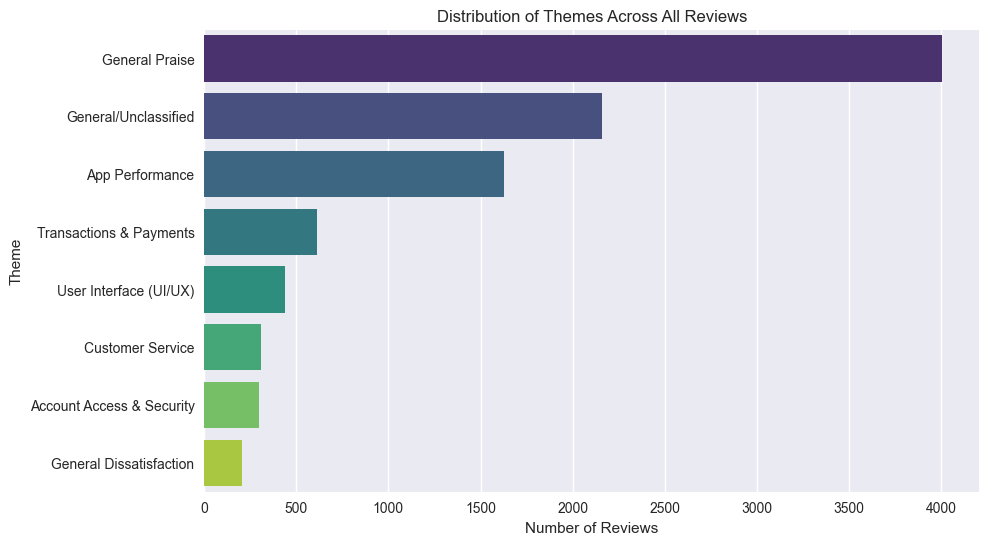

In [4]:
plt.figure(figsize=(10, 6))
theme_counts = df['identified_theme'].value_counts()
sns.barplot(x=theme_counts.values, y=theme_counts.index, palette='viridis')
plt.title('Distribution of Themes Across All Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Theme')
plt.show()

## 3. Theme Distribution by Bank
Which banks struggle with which issues? (e.g., Does one bank have more 'Login' issues than others?)

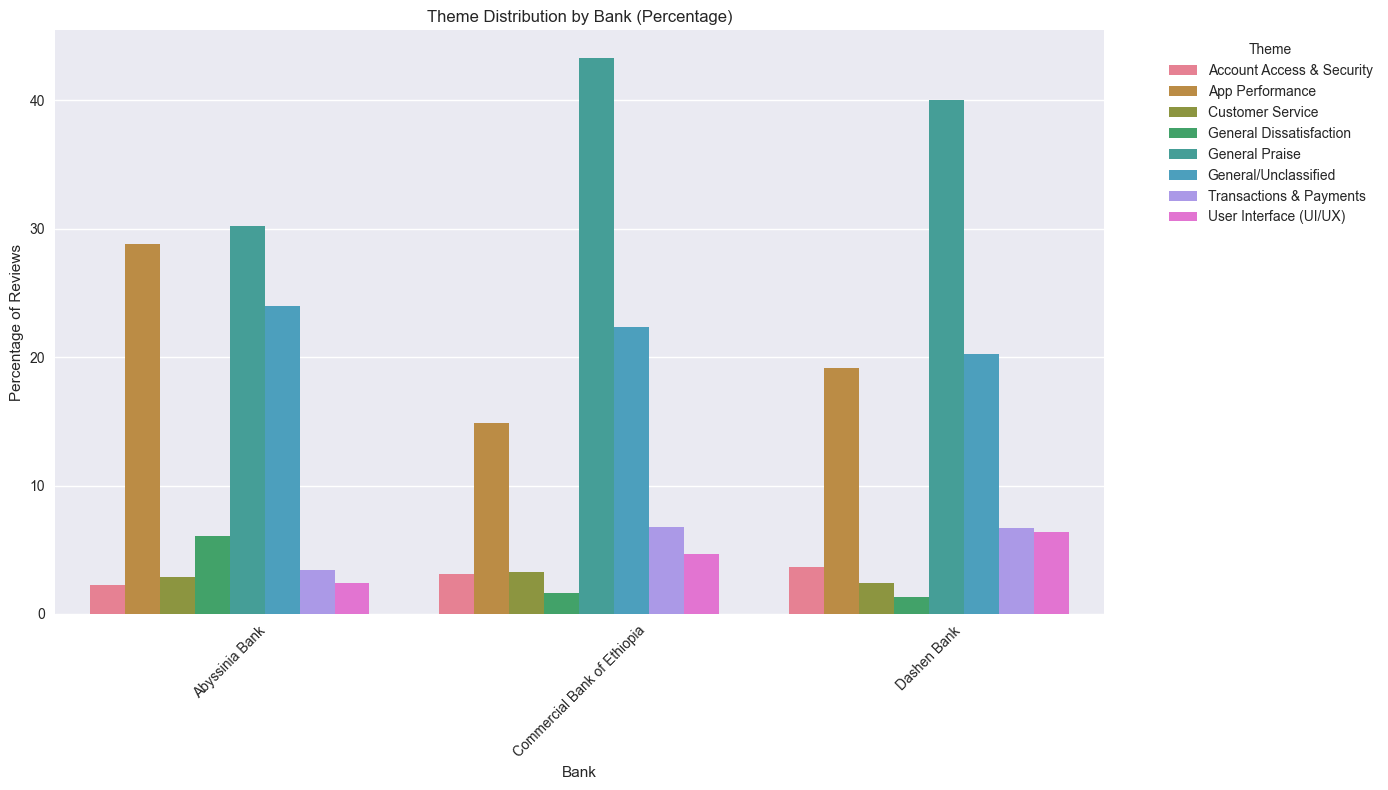

In [5]:
# Calculate percentage of themes per bank to normalize for different review counts
theme_by_bank = df.groupby(['bank_name', 'identified_theme']).size().reset_index(name='count')
total_by_bank = df.groupby('bank_name').size().reset_index(name='total')
theme_by_bank = theme_by_bank.merge(total_by_bank, on='bank_name')
theme_by_bank['percentage'] = (theme_by_bank['count'] / theme_by_bank['total']) * 100

plt.figure(figsize=(14, 8))
sns.barplot(data=theme_by_bank, x='bank_name', y='percentage', hue='identified_theme')
plt.title('Theme Distribution by Bank (Percentage)')
plt.xlabel('Bank')
plt.ylabel('Percentage of Reviews')
plt.legend(title='Theme', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Sentiment by Theme
Are certain themes associated with more negative sentiment? (e.g., 'Account Access' might be more negative than 'UI/UX')

C:\Users\yeget\AppData\Local\Temp\ipykernel_30772\1203806587.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='identified_theme', y=score_col, palette='coolwarm')


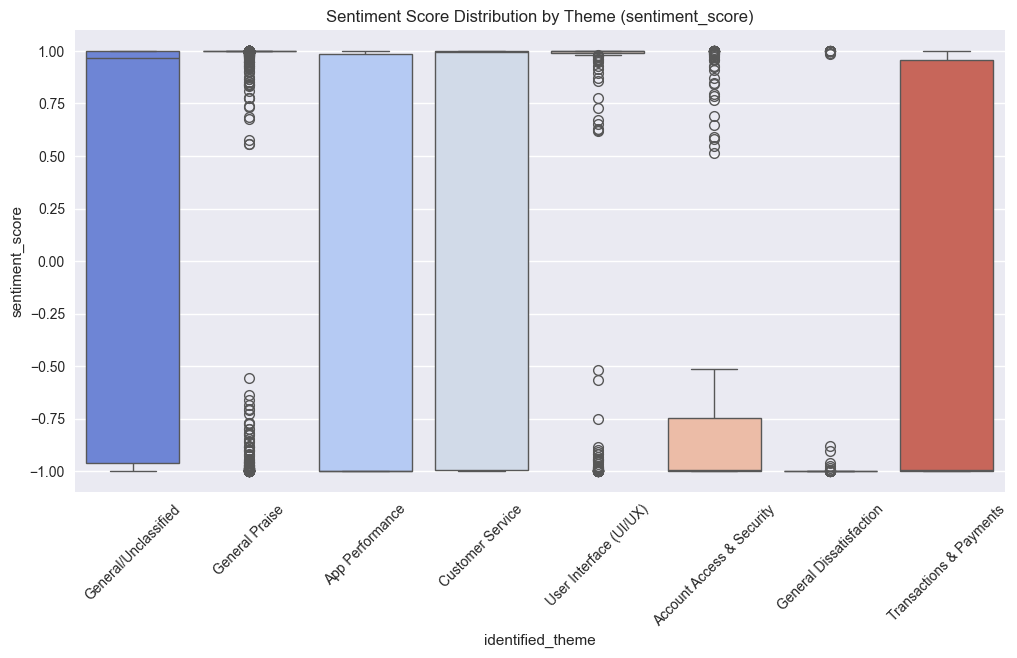

In [6]:
plt.figure(figsize=(12, 6))
# Using 'sentiment_score' (VADER) or 'bert_score' if available. Defaulting to 'sentiment_score' for now.
score_col = 'sentiment_score' if 'sentiment_score' in df.columns else 'bert_score'

sns.boxplot(data=df, x='identified_theme', y=score_col, palette='coolwarm')
plt.title(f'Sentiment Score Distribution by Theme ({score_col})')
plt.xticks(rotation=45)
plt.show()

## 5. Word Clouds per Theme
Visualizing the most frequent words within each theme to verify our classification.

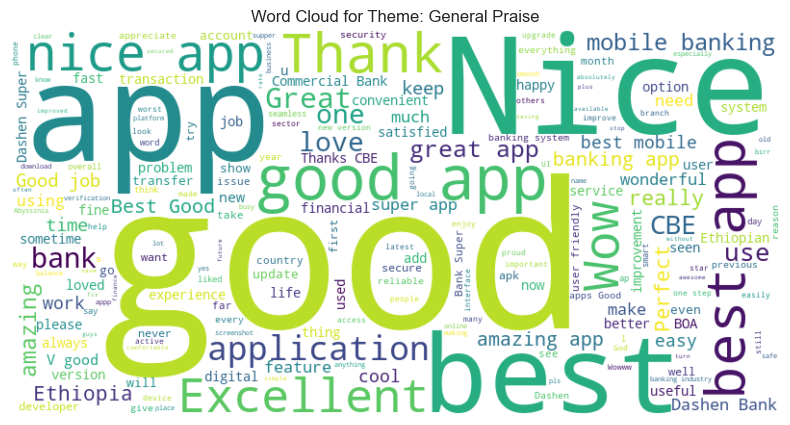

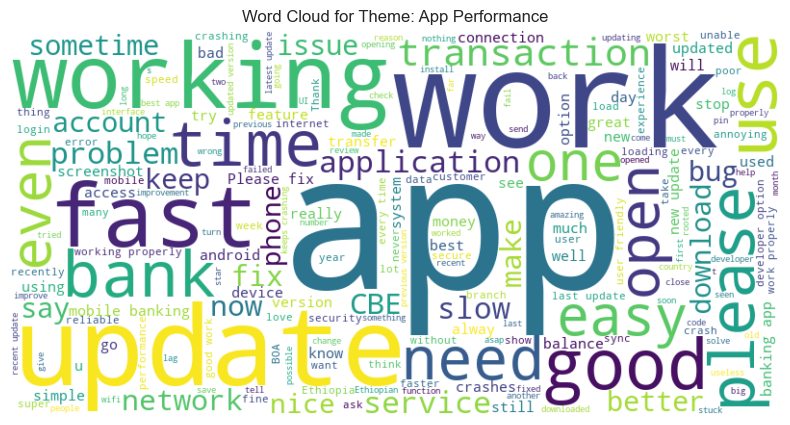

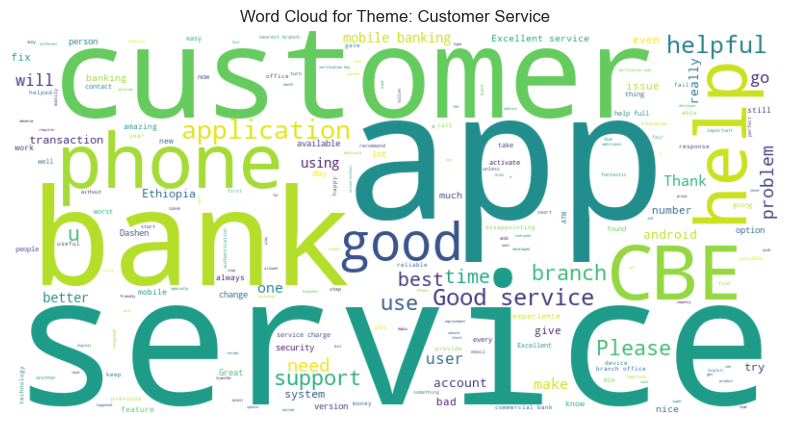

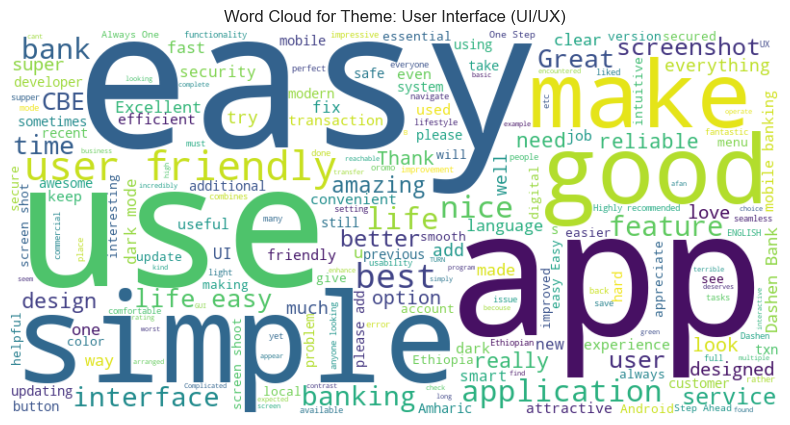

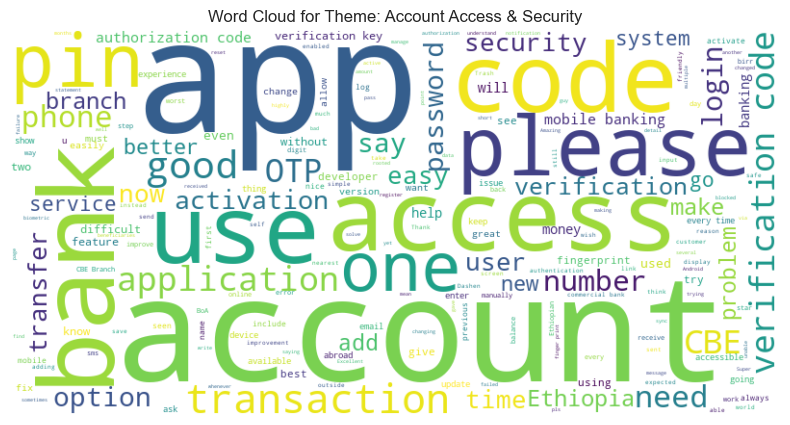

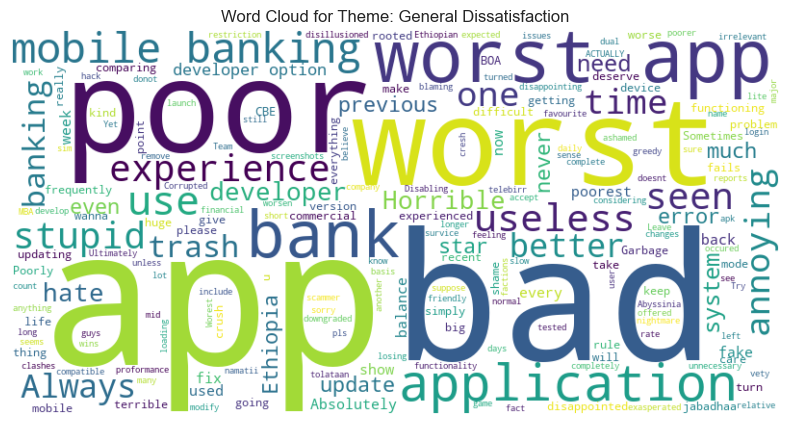

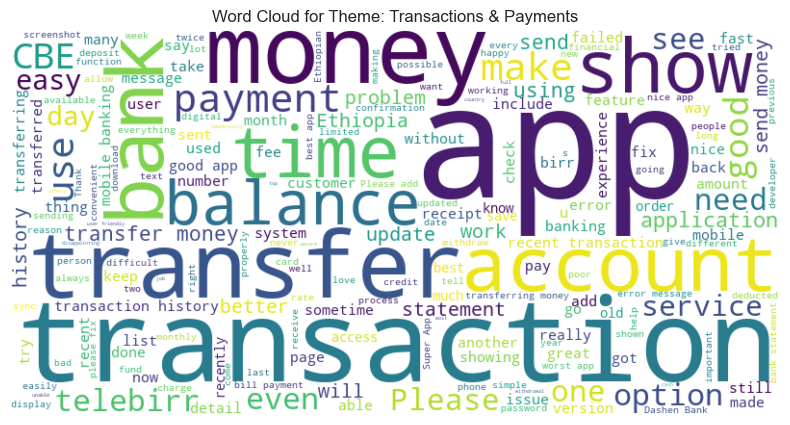

In [7]:
themes = df['identified_theme'].unique()

for theme in themes:
    if theme == 'General/Unclassified': continue
    
    subset = df[df['identified_theme'] == theme]
    text = " ".join(subset['review_text'].astype(str))
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Theme: {theme}')
    plt.show()